In [110]:
"""Import the necessary modules:""" 

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
pd.set_option("display.max_columns", 999)
pd.set_option("display.max_rows", 100)

import numpy as np

import pandas_profiling

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("dark")
sns.set_context("talk")
import itertools

from statistics import mode

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectFromModel
from scipy import stats

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, auc, classification_report, confusion_matrix
from sklearn.externals.six import StringIO
from IPython.display import Image
from sklearn.tree import export_graphviz
import pydotplus

import functions as func
%reload_ext autoreload
%autoreload 2

# Data Cleaning and Exploratory Data Analysis

In [2]:
df = pd.read_excel("default of credit card clients.xls", skiprows = 1)
df.head()

ID  LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_0  PAY_2  PAY_3  PAY_4  \
0   1      20000    2          2         1   24      2      2     -1     -1   
1   2     120000    2          2         2   26     -1      2      0      0   
2   3      90000    2          2         2   34      0      0      0      0   
3   4      50000    2          2         1   37      0      0      0      0   
4   5      50000    1          2         1   57     -1      0     -1      0   

   PAY_5  PAY_6  BILL_AMT1  BILL_AMT2  BILL_AMT3  BILL_AMT4  BILL_AMT5  \
0     -2     -2       3913       3102        689          0          0   
1      0      2       2682       1725       2682       3272       3455   
2      0      0      29239      14027      13559      14331      14948   
3      0      0      46990      48233      49291      28314      28959   
4      0      0       8617       5670      35835      20940      19146   

   BILL_AMT6  PAY_AMT1  PAY_AMT2  PAY_AMT3  PAY_AMT4  PAY_AMT5  PAY_AMT6  \
0          0         0       689         0         0         0         0   
1       3261         0      1000      1000      1000         0      2000   
2      15549      1518      1500      1000      1000      1000      5000   
3      29547      2000      2019      1200      1100      1069      1000   
4      19131      2000     36681     10000      9000       689       679   

   default payment next month  
0                           1  
1                           1  
2                           0  
3                           0  
4                           0

In [3]:
#Rename column headers to indicate months
df.rename(mapper = {"MARRIAGE" : "marital_status", "PAY_0" : "pay_sep", "PAY_2" : "pay_aug", "PAY_3" : "pay_jul", "PAY_4" : "pay_jun",
                    "PAY_5" : "pay_may", "PAY_6" : "pay_apr", "BILL_AMT1" : "bill_amt_sep", "BILL_AMT2" : "bill_amt_aug", "BILL_AMT3" : "bill_amt_jul",
                    "BILL_AMT4" : "bill_amt_jun", "BILL_AMT5" : "bill_amt_may", "BILL_AMT6" : "bill_amt_apr", "PAY_AMT1" : "pay_amt_sep",
                    "PAY_AMT2" : "pay_amt_aug", "PAY_AMT3" : "pay_amt_jul", "PAY_AMT4" : "pay_amt_jun", "PAY_AMT5" : "pay_amt_may",
                    "PAY_AMT6" : "pay_amt_apr", "default payment next month":"default_payment_next_month"}, axis = 1, inplace = True)
df.columns = df.columns.map(lambda x: x.lower())

#Descriptive statistics
df.describe(include = "all").T

count           mean            std       min  \
id                          30000.0   15000.500000    8660.398374       1.0   
limit_bal                   30000.0  167484.322667  129747.661567   10000.0   
sex                         30000.0       1.603733       0.489129       1.0   
education                   30000.0       1.853133       0.790349       0.0   
marital_status              30000.0       1.551867       0.521970       0.0   
age                         30000.0      35.485500       9.217904      21.0   
pay_sep                     30000.0      -0.016700       1.123802      -2.0   
pay_aug                     30000.0      -0.133767       1.197186      -2.0   
pay_jul                     30000.0      -0.166200       1.196868      -2.0   
pay_jun                     30000.0      -0.220667       1.169139      -2.0   
pay_may                     30000.0      -0.266200       1.133187      -2.0   
pay_apr                     30000.0      -0.291100       1.149988      -2.0   
bill_amt_sep                30000.0   51223.330900   73635.860576 -165580.0   
bill_amt_aug                30000.0   49179.075167   71173.768783  -69777.0   
bill_amt_jul                30000.0   47013.154800   69349.387427 -157264.0   
bill_amt_jun                30000.0   43262.948967   64332.856134 -170000.0   
bill_amt_may                30000.0   40311.400967   60797.155770  -81334.0   
bill_amt_apr                30000.0   38871.760400   59554.107537 -339603.0   
pay_amt_sep                 30000.0    5663.580500   16563.280354       0.0   
pay_amt_aug                 30000.0    5921.163500   23040.870402       0.0   
pay_amt_jul                 30000.0    5225.681500   17606.961470       0.0   
pay_amt_jun                 30000.0    4826.076867   15666.159744       0.0   
pay_amt_may                 30000.0    4799.387633   15278.305679       0.0   
pay_amt_apr                 30000.0    5215.502567   17777.465775       0.0   
default_payment_next_month  30000.0       0.221200       0.415062       0.0   

                                 25%       50%        75%        max  
id                           7500.75   15000.5   22500.25    30000.0  
limit_bal                   50000.00  140000.0  240000.00  1000000.0  
sex                             1.00       2.0       2.00        2.0  
education                       1.00       2.0       2.00        6.0  
marital_status                  1.00       2.0       2.00        3.0  
age                            28.00      34.0      41.00       79.0  
pay_sep                        -1.00       0.0       0.00        8.0  
pay_aug                        -1.00       0.0       0.00        8.0  
pay_jul                        -1.00       0.0       0.00        8.0  
pay_jun                        -1.00       0.0       0.00        8.0  
pay_may                        -1.00       0.0       0.00        8.0  
pay_apr                        -1.00       0.0       0.00        8.0  
bill_amt_sep                 3558.75   22381.5   67091.00   964511.0  
bill_amt_aug                 2984.75   21200.0   64006.25   983931.0  
bill_amt_jul                 2666.25   20088.5   60164.75  1664089.0  
bill_amt_jun                 2326.75   19052.0   54506.00   891586.0  
bill_amt_may                 1763.00   18104.5   50190.50   927171.0  
bill_amt_apr                 1256.00   17071.0   49198.25   961664.0  
pay_amt_sep                  1000.00    2100.0    5006.00   873552.0  
pay_amt_aug                   833.00    2009.0    5000.00  1684259.0  
pay_amt_jul                   390.00    1800.0    4505.00   896040.0  
pay_amt_jun                   296.00    1500.0    4013.25   621000.0  
pay_amt_may                   252.50    1500.0    4031.50   426529.0  
pay_amt_apr                   117.75    1500.0    4000.00   528666.0  
default_payment_next_month      0.00       0.0       0.00        1.0

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
id                            30000 non-null int64
limit_bal                     30000 non-null int64
sex                           30000 non-null int64
education                     30000 non-null int64
marital_status                30000 non-null int64
age                           30000 non-null int64
pay_sep                       30000 non-null int64
pay_aug                       30000 non-null int64
pay_jul                       30000 non-null int64
pay_jun                       30000 non-null int64
pay_may                       30000 non-null int64
pay_apr                       30000 non-null int64
bill_amt_sep                  30000 non-null int64
bill_amt_aug                  30000 non-null int64
bill_amt_jul                  30000 non-null int64
bill_amt_jun                  30000 non-null int64
bill_amt_may                  30000 non-null int64
bill_amt_apr            

In [5]:
#Run a profiling for the initial checks
creditcard_report = df.profile_report(title="Credit Card Clients Detailed Profiling Report", correlation_threshold_pearson = 1, sort = "None")
creditcard_report.to_file(output_file="creditcard.html")
creditcard_report

#### Based on the above report:

Data Cleaning:
- 'sex': There are 18112 female clients, 60.4% of the dataset. 
- 'education': Delete column values 5,6,0, only 1.1% of the dataset.
- 'marital_status': Delete column values 0, only 0.2% of the dataset.
- 'bill_amt_apr' to 'bill_amt_sep': There are negative amounts: overpayment.
- 'default_payment_next_month': This will be our target variable. There are 23364 '0' values we will then need to employ the Synthetic Minority Oversampling technique.

Feature Engineering:
- Add % of credit limit used by dividing billed amount as of September 2005 (bill_amt_sep) over limit balance (limit_bal). This can tell us how much is unpaid vs the approved credit limit.
- Add sum of payment status for the past 3 and 6 months.  Higher sum means worse credit standing for the past 3 and 6 months.
- Add payment status for the past 3 months by taking the mode or 'pay_sep' for EDA purposes.
- Recategorize 'pay_apr' to 'pay_3mos' and age for EDA purposes.
- Convert 'sex', 'education' and 'marital status' into dummy variables.
- Employ PCA to transform highly correlated columns 'bill_amt_apr' to 'bill_amt_sep' and 'pay_amt_apr' to 'pay_amt_sep'

In [6]:
#Delete unknown entries under 'education' and 'marital_status'
func.delete_entries(df, "education", [5,6,0])
func.delete_entries(df, "marital_status", [0])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29601 entries, 0 to 29999
Data columns (total 25 columns):
id                            29601 non-null int64
limit_bal                     29601 non-null int64
sex                           29601 non-null int64
education                     29601 non-null int64
marital_status                29601 non-null int64
age                           29601 non-null int64
pay_sep                       29601 non-null int64
pay_aug                       29601 non-null int64
pay_jul                       29601 non-null int64
pay_jun                       29601 non-null int64
pay_may                       29601 non-null int64
pay_apr                       29601 non-null int64
bill_amt_sep                  29601 non-null int64
bill_amt_aug                  29601 non-null int64
bill_amt_jul                  29601 non-null int64
bill_amt_jun                  29601 non-null int64
bill_amt_may                  29601 non-null int64
bill_amt_apr            

In [7]:
#Add a column for % of credit limit used by dividing billed amount as of September 2005 (bill_amt_sep) over limit balance (limit_bal).
df["limit_used_sep"] = df["bill_amt_sep"] / df["limit_bal"]

#Add a column for "mode" payment history for the past 3 mos. Otherwise, take pay_sep.
df["pay_mode3"] = pd.Series([])
for i in range(len(df)):
    try:
        df["pay_mode3"].iloc[i] = mode([df["pay_sep"].iloc[i], df["pay_aug"].iloc[i], df["pay_jul"].iloc[i]])
    except:
        df["pay_mode3"].iloc[i] = df["pay_sep"].iloc[i]
    else:
        df["pay_mode3"].iloc[i] = mode([df["pay_sep"].iloc[i], df["pay_aug"].iloc[i], df["pay_jul"].iloc[i]])
df["pay_mode3"] = df["pay_mode3"].astype("int64")

#Add payment history for the past 3 and 6 months.
df["score_3mo"] = df["pay_sep"] + df["pay_aug"] + df["pay_jul"] 
df["score_6mo"] = df["pay_sep"] + df["pay_aug"] + df["pay_jul"] + df["pay_jun"] + df["pay_may"] + df["pay_apr"]

#Recategorized the pay and age columns
columns = ['pay_mode3','pay_sep', 'pay_aug', 'pay_jul', 'pay_jun', 'pay_may', 'pay_apr']
for col in columns:
    df[col+"_cat"] = df[col].map(lambda x: -1 if x<0 else (1 if x>0 else x))

df["age_cat"] = df["age"].map(lambda x: "20-29" if x < 30 else ("30-39" if x < 40 else ("40-49" if x < 50 else ("50-59" if x < 60 else "60 up"))))

df.head()

id  limit_bal  sex  education  marital_status  age  pay_sep  pay_aug  \
0   1      20000    2          2               1   24        2        2   
1   2     120000    2          2               2   26       -1        2   
2   3      90000    2          2               2   34        0        0   
3   4      50000    2          2               1   37        0        0   
4   5      50000    1          2               1   57       -1        0   

   pay_jul  pay_jun  pay_may  pay_apr  bill_amt_sep  bill_amt_aug  \
0       -1       -1       -2       -2          3913          3102   
1        0        0        0        2          2682          1725   
2        0        0        0        0         29239         14027   
3        0        0        0        0         46990         48233   
4       -1        0        0        0          8617          5670   

   bill_amt_jul  bill_amt_jun  bill_amt_may  bill_amt_apr  pay_amt_sep  \
0           689             0             0             0            0   
1          2682          3272          3455          3261            0   
2         13559         14331         14948         15549         1518   
3         49291         28314         28959         29547         2000   
4         35835         20940         19146         19131         2000   

   pay_amt_aug  pay_amt_jul  pay_amt_jun  pay_amt_may  pay_amt_apr  \
0          689            0            0            0            0   
1         1000         1000         1000            0         2000   
2         1500         1000         1000         1000         5000   
3         2019         1200         1100         1069         1000   
4        36681        10000         9000          689          679   

   default_payment_next_month  limit_used_sep  pay_mode3  score_3mo  \
0                           1        0.195650          2          3   
1                           1        0.022350         -1          1   
2                           0        0.324878          0          0   
3                           0        0.939800          0          0   
4                           0        0.172340         -1         -2   

   score_6mo  pay_mode3_cat  pay_sep_cat  pay_aug_cat  pay_jul_cat  \
0         -2              1            1            1           -1   
1          3             -1           -1            1            0   
2          0              0            0            0            0   
3          0              0            0            0            0   
4         -2             -1           -1            0           -1   

   pay_jun_cat  pay_may_cat  pay_apr_cat age_cat  
0           -1           -1           -1   20-29  
1            0            0            1   20-29  
2            0            0            0   30-39  
3            0            0            0   30-39  
4            0            0            0   50-59

In [8]:
df.to_csv("df.csv", index = False)

In [123]:
df = pd.read_csv("df.csv")

In [145]:
#Systematically remove the outliers using z-score.  Here we are removing data outside of +/-3 std

cont = ['limit_bal','age','limit_used_sep', 'score_3mo', 'score_6mo', 'bill_amt_sep', 'bill_amt_aug', 'bill_amt_jul', 'bill_amt_jun',
           'bill_amt_may', 'bill_amt_apr', 'pay_amt_sep', 'pay_amt_aug', 'pay_amt_jul', 'pay_amt_jun', 'pay_amt_may', 'pay_amt_apr']
df_cont = df[cont]
df_cat = df.drop(cont, axis = 1)
df_cont_cleaned = df_cont[(np.abs(stats.zscore(df_cont)) < 3).all(axis = 1)]

df = pd.concat([df_cat.default_payment_next_month, df_cont_cleaned, df_cat.drop(["default_payment_next_month"], axis = 1)], axis = 1, join = "inner")

display(df.shape, df_cont.shape, df_cont_cleaned.shape, df_cat.shape)

(22561, 37)

(26433, 17)

(22561, 17)

(26433, 20)

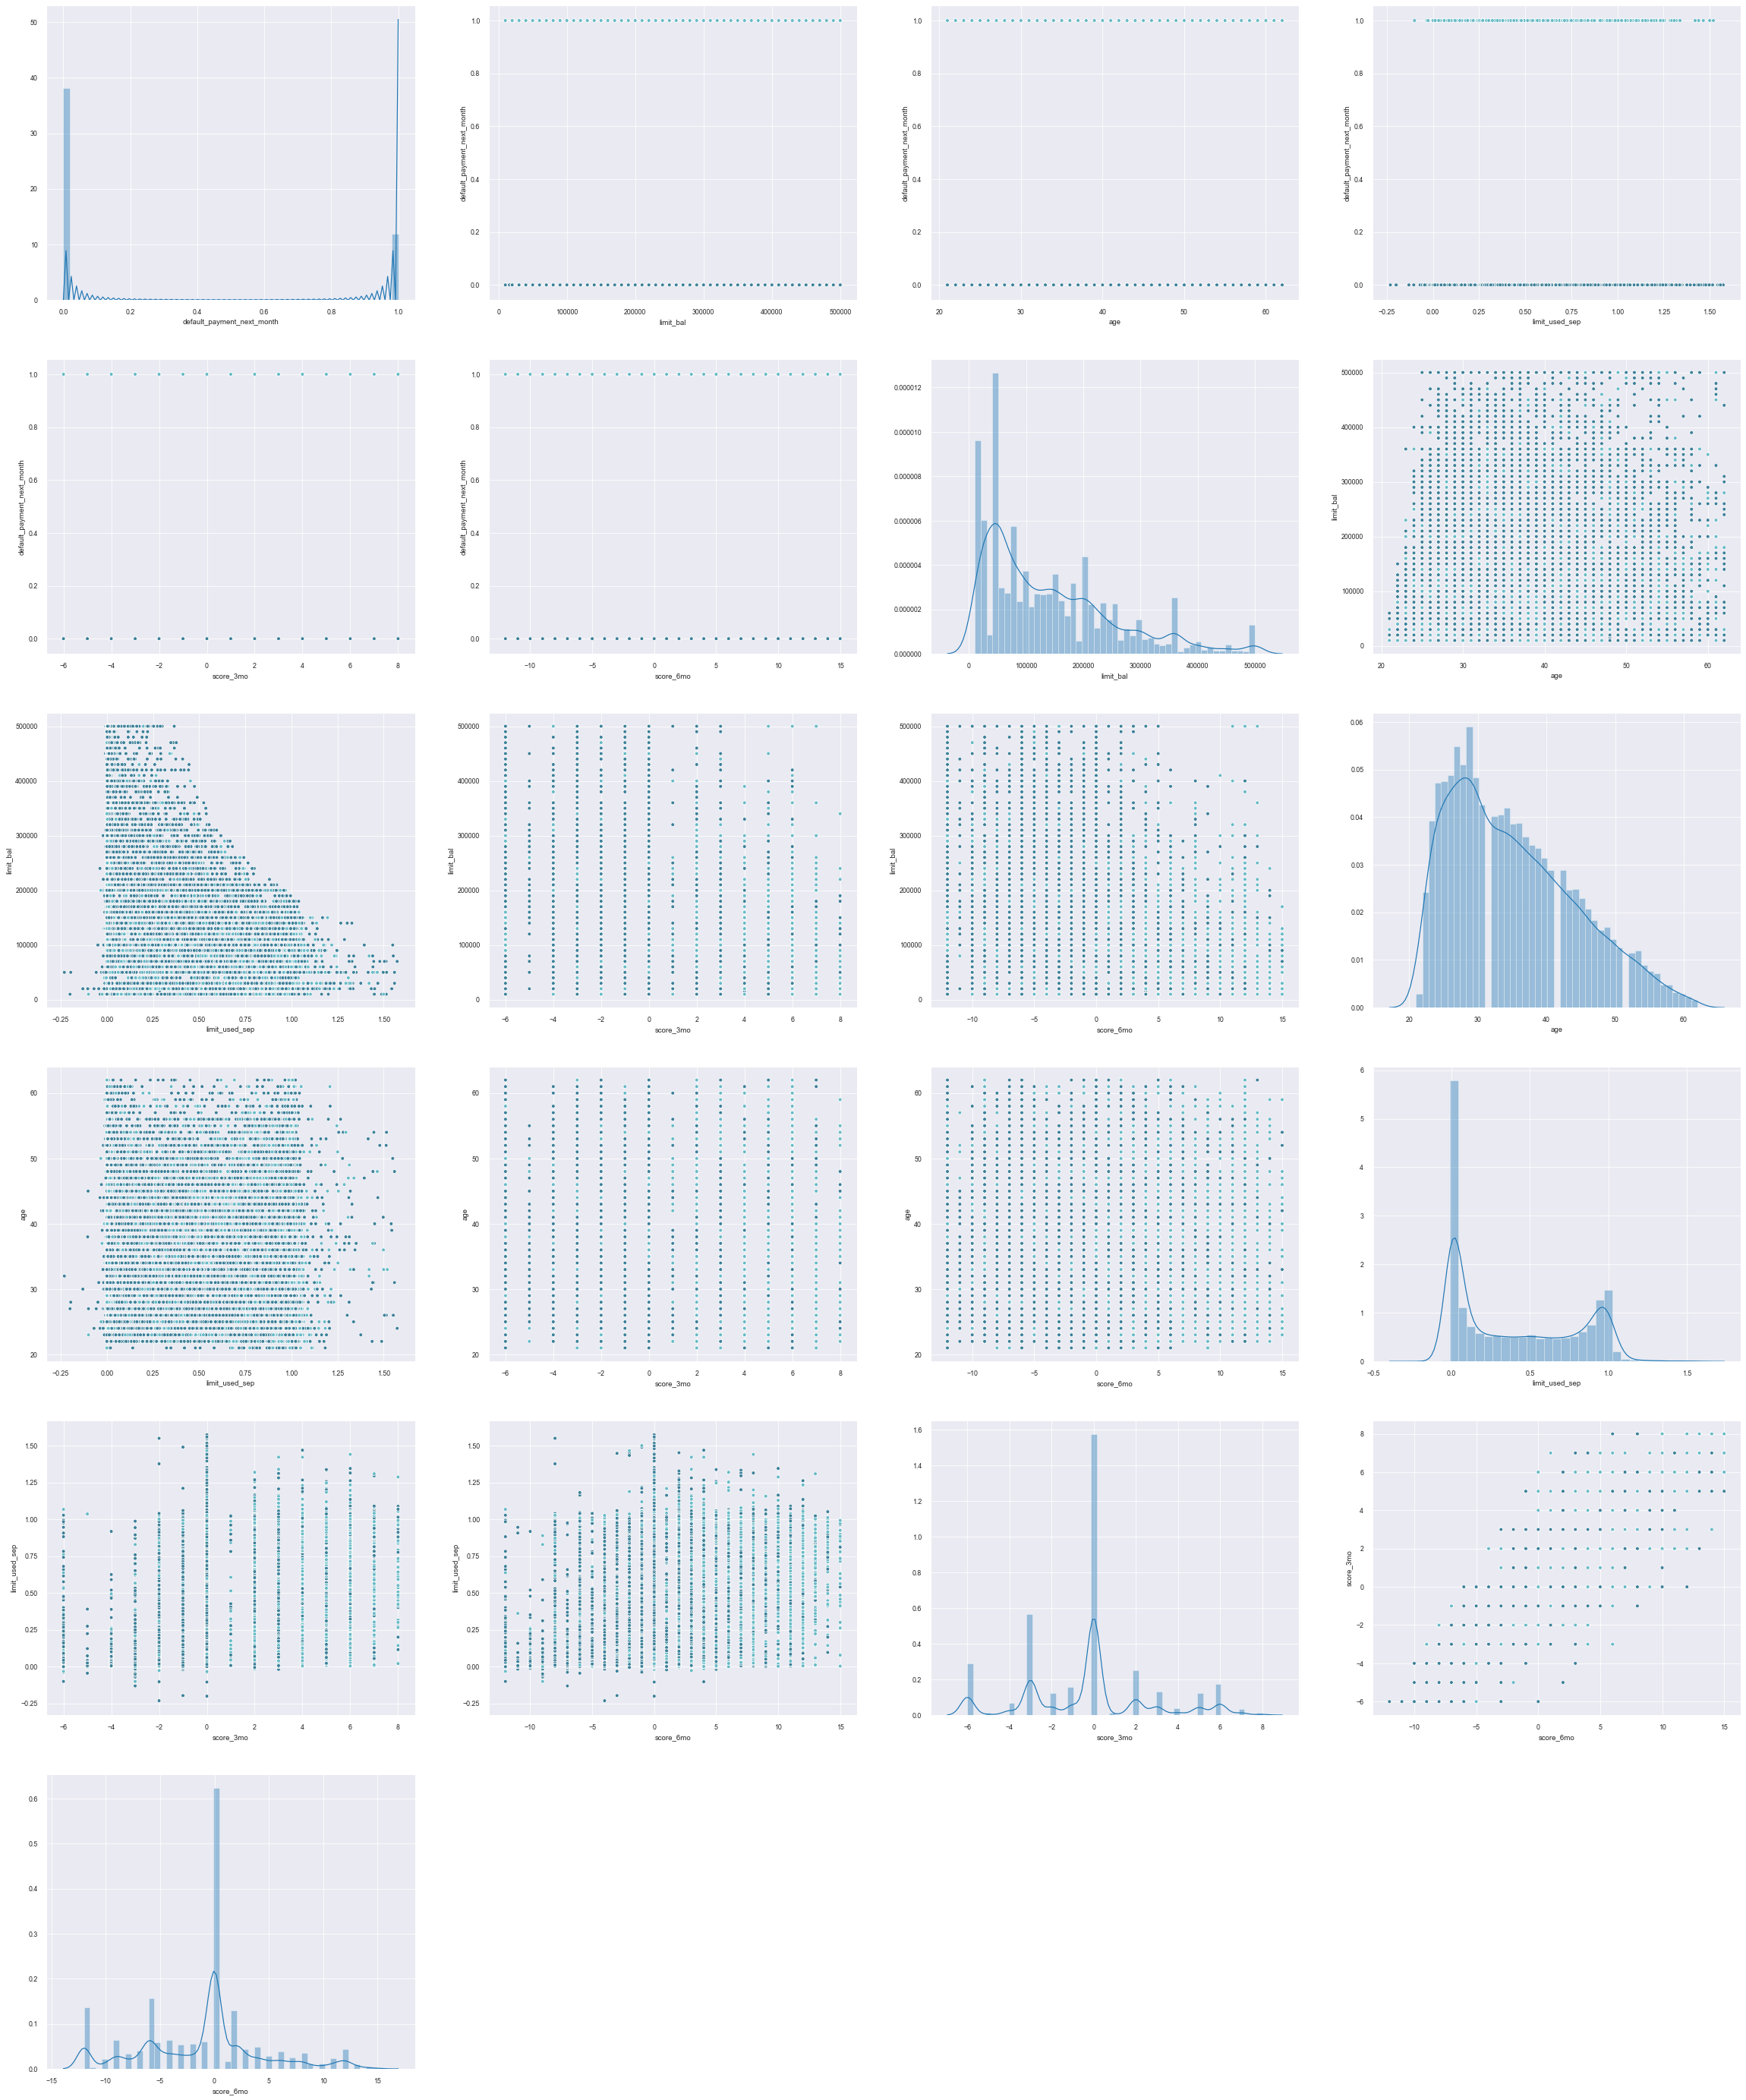

In [146]:
#Let's create pairwise plots of continuous and target variables
columns = ['default_payment_next_month','limit_bal','age','limit_used_sep', 'score_3mo', 'score_6mo']
func.plot_cf_target(df, columns)

#### Based on the above plots:

- 'score_3mo' and 'score_6mo' have linear relationship
- those who have low 'score_3mo' and 'score_6mo' have low credit limit as well

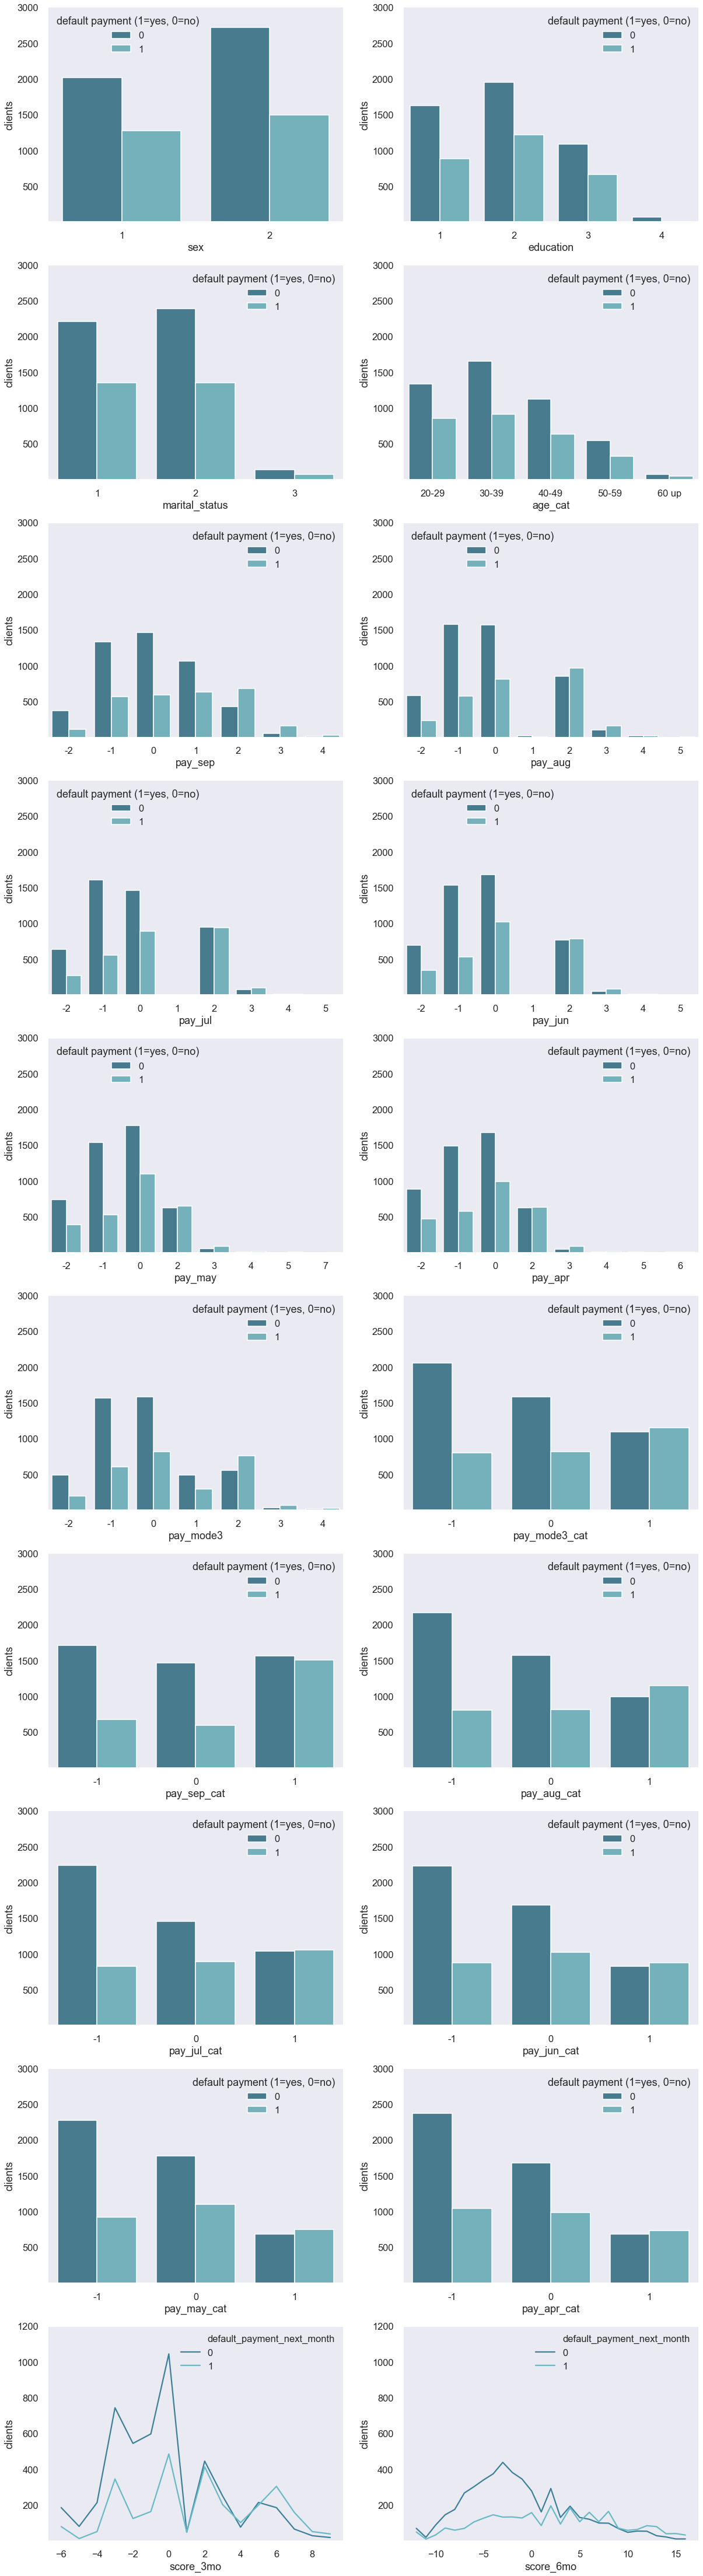

In [125]:
#Let's create plots of the categorical features

cat = ['sex', 'education', 'marital_status', 'age_cat', 'pay_sep', 'pay_aug', 'pay_jul', 'pay_jun', 'pay_may', 'pay_apr','pay_mode3',
       'pay_mode3_cat', 'pay_sep_cat', 'pay_aug_cat', 'pay_jul_cat', 'pay_jun_cat', 'pay_may_cat','pay_apr_cat', 'score_3mo', 'score_6mo']
columns = ['sex', 'education', 'marital_status', 'age_cat', 'pay_sep', 'pay_aug', 'pay_jul', 'pay_jun', 'pay_may', 'pay_apr','pay_mode3',
           'pay_mode3_cat', 'pay_sep_cat', 'pay_aug_cat', 'pay_jul_cat', 'pay_jun_cat', 'pay_may_cat','pay_apr_cat', 'score_3mo',
           'score_6mo','default_payment_next_month', 'id']
pivot = df[columns].groupby(['sex', 'education', 'marital_status', 'age_cat', 'pay_sep', 'pay_aug', 'pay_jul', 'pay_jun', 'pay_may', 'pay_apr',
                             'pay_mode3','pay_mode3_cat', 'pay_sep_cat', 'pay_aug_cat', 'pay_jul_cat', 'pay_jun_cat', 'pay_may_cat',
                             'pay_apr_cat','score_3mo', 'score_6mo', 'default_payment_next_month']).count()
pivot.reset_index(inplace = True)

func.plot_cat(pivot, cat)

#### Based on the above plots:

- 'score_3mo' and 'score_6mo' have linear relationship

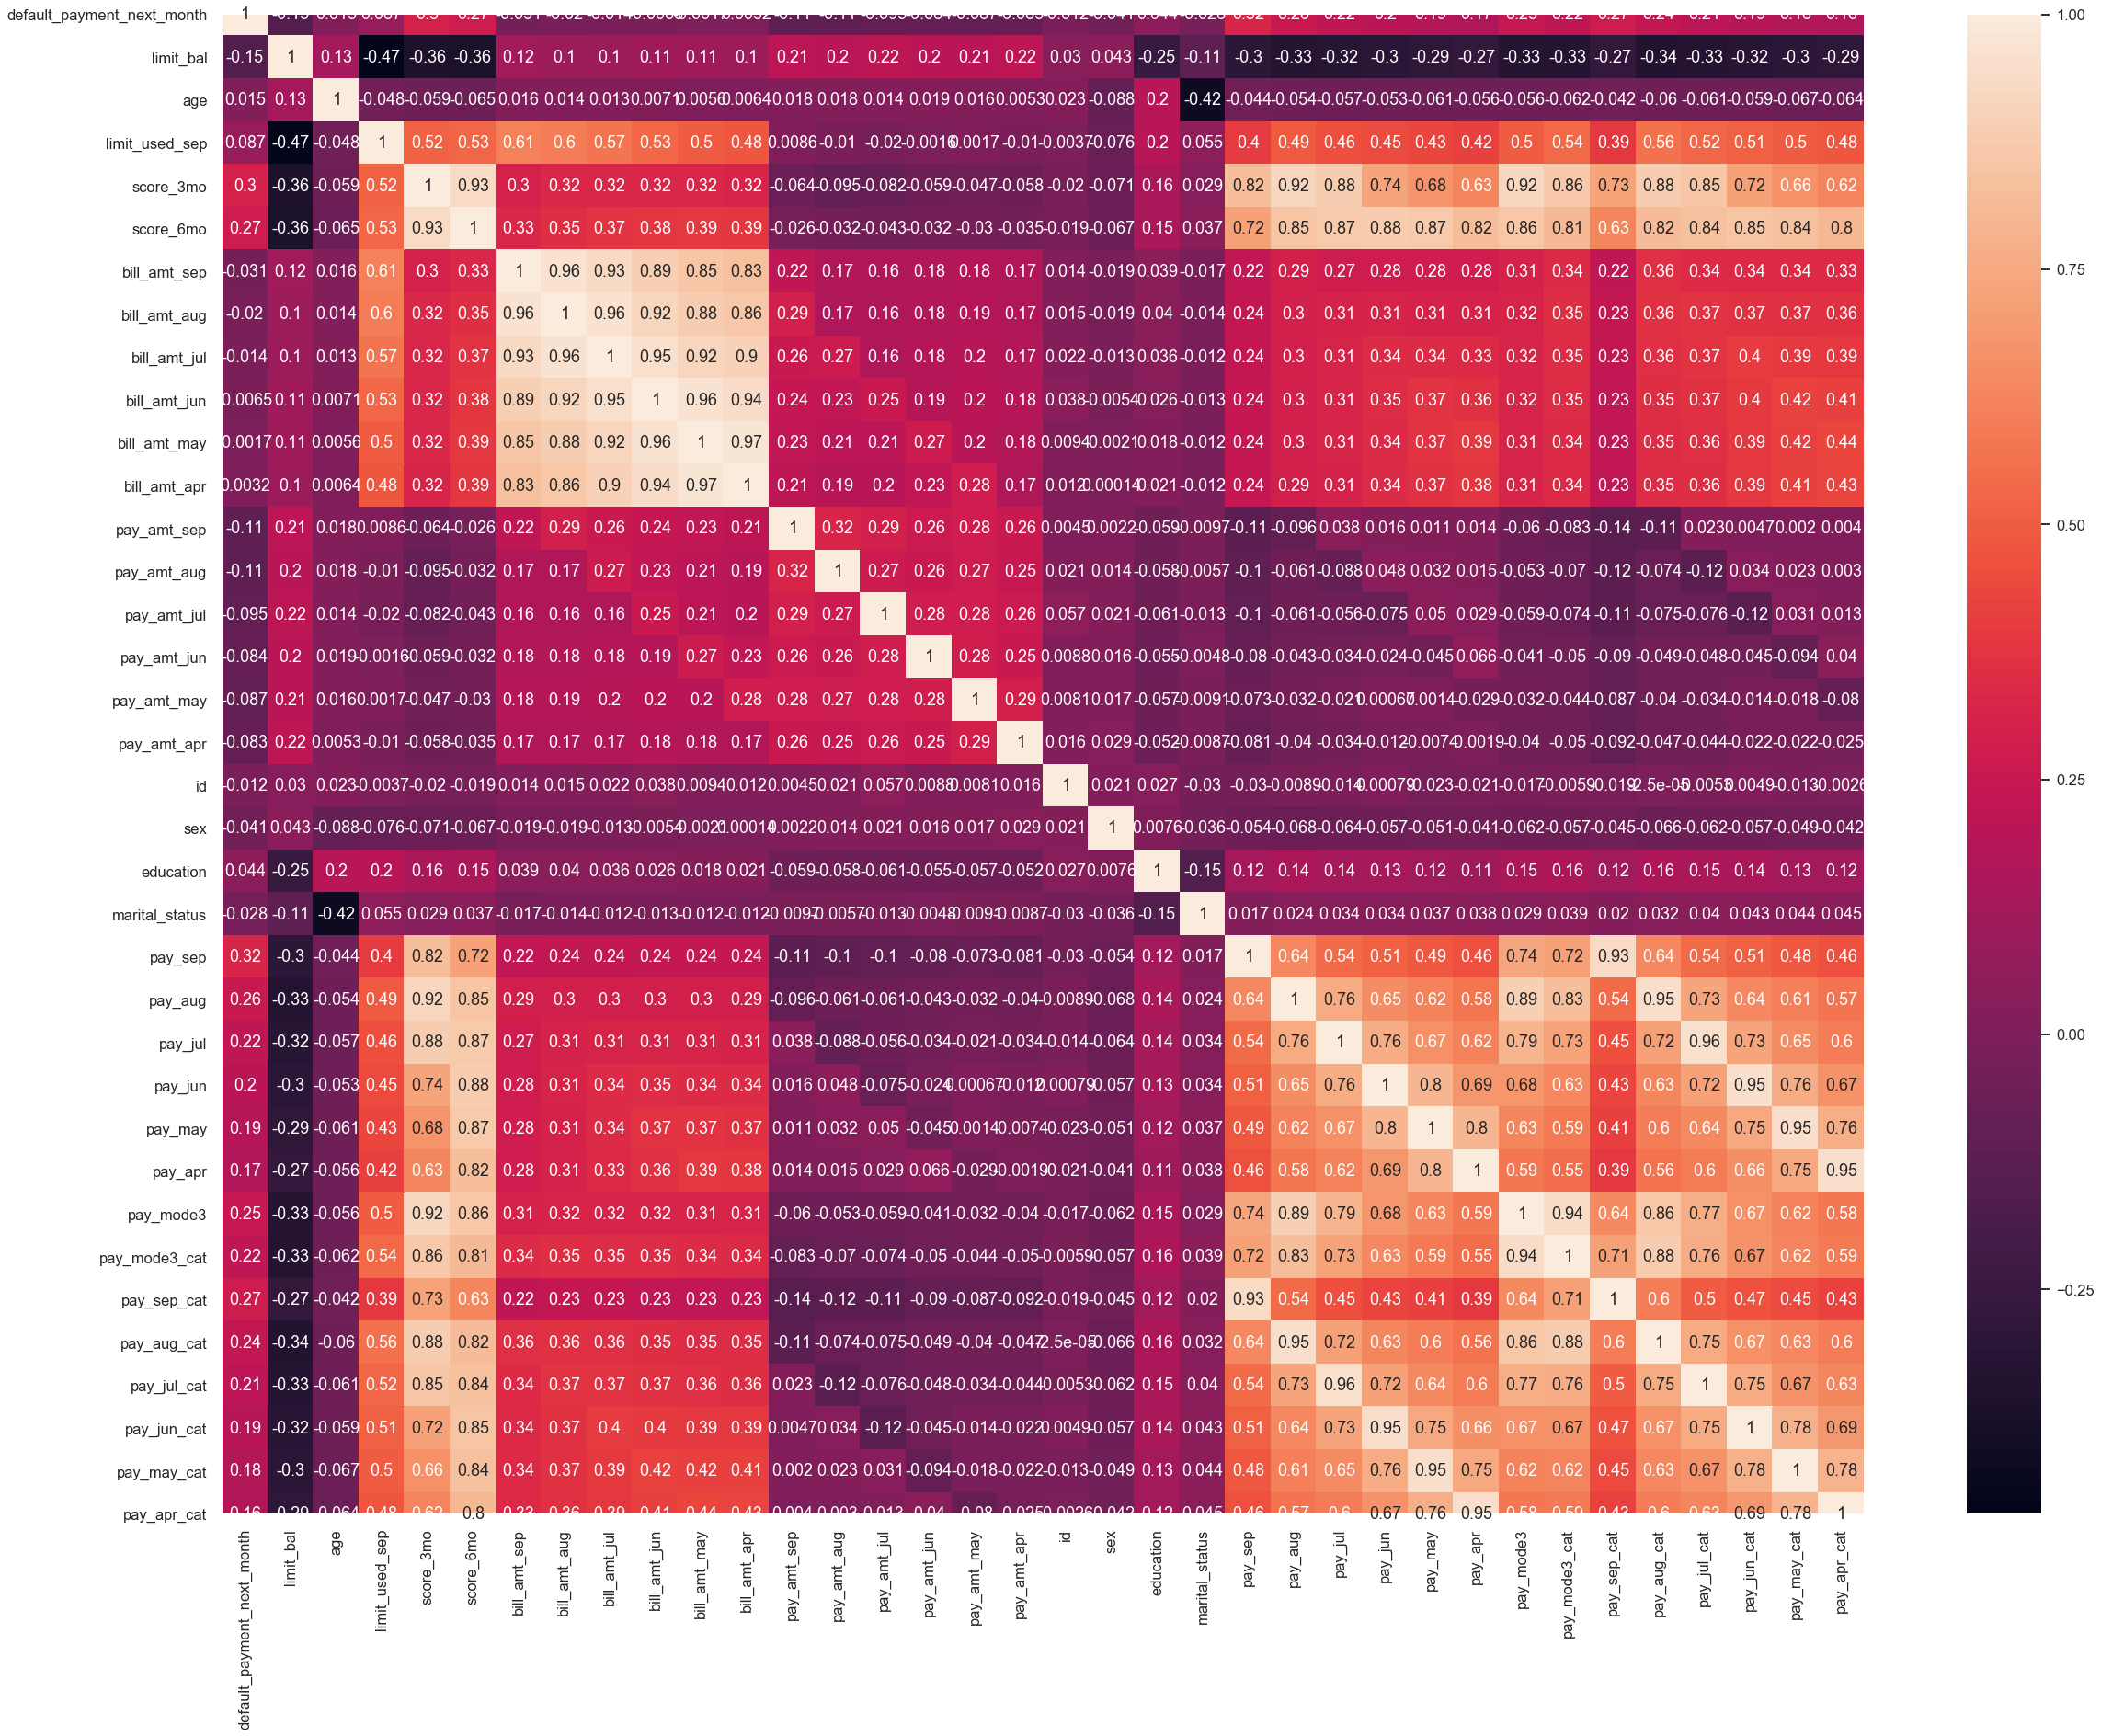

In [126]:
plt.figure(figsize=(40, 30))
sns.heatmap(data = df.corr(), annot=True);

#### Based on the above matrix:

-  'default_payment_next_month' has no strong correlation with any of the features.
- 'pay_apr' to 'pay_sep' columns are highly correlated.
- 'bill_amt_apr' to 'bill_amt_sep' columns are highly correlated.

#### Findings here

In [138]:
df.to_csv("df_cleaned.csv", index = False)

In [147]:
df_final = pd.read_csv("df_cleaned.csv")

#  Models

#### Logistic Regression. In this section, we will:

- Define categorical and continuous features then convert categorical to dummy variables.
- Split the dataset into train and test.  Use SMOTE to deal with the class imbalance.
- Use SelectForModel for feature selection then run Logistic Regression.
- Select features manually then run Logistic Regression.
- Select the model with the higher F1 score.
- Use GridSearchCV to optimise the model.


In [148]:
#Create categorical and continuous features column header lists
cat_columns = ['sex', 'education', 'marital_status','pay_sep', 'pay_aug', 'pay_jul', 'pay_jun', 'pay_may', 'pay_apr']
cf_columns = ['age','limit_bal','limit_used_sep', 'score_3mo', 'score_6mo']

#Convert cat to dummies, split the data then run SMOTE and SelectFromModel
selected, X_train_selected, X_test_selected, y_train, y_test = func.feature_selection_Logistic(df_final, cat_columns, cf_columns)

dummy variables created
split done
original class distribution:
0    20424
1     6009
Name: default_payment_next_month, dtype: int64
synthetic sample class distribution:
1    15277
0    15277
dtype: int64
scaling done
19  features selected out of  52


In [149]:
#Selected features by SelectFromModel
selected_list = [key for key, value in selected.items() if value == True]
selected_list

['limit_bal',
 'limit_used_sep',
 'score_3mo',
 'education_others',
 'pay_sep_-1',
 'pay_sep_1',
 'pay_sep_2',
 'pay_sep_3',
 'pay_sep_4',
 'pay_aug_-1',
 'pay_aug_1',
 'pay_aug_2',
 'pay_aug_4',
 'pay_jul_1',
 'pay_may_4',
 'pay_may_5',
 'pay_apr_0',
 'pay_apr_3',
 'pay_apr_5']

Classification Report: 
               precision    recall  f1-score   support

           0       0.87      0.82      0.85      5147
           1       0.48      0.57      0.52      1462

    accuracy                           0.77      6609
   macro avg       0.67      0.70      0.68      6609
weighted avg       0.78      0.77      0.77      6609

AUC: 0.754054199157625


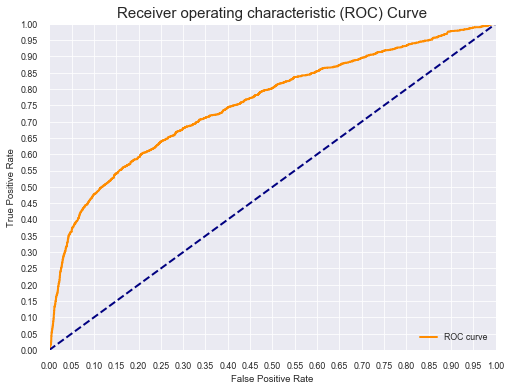

Confusion matrix, without normalization


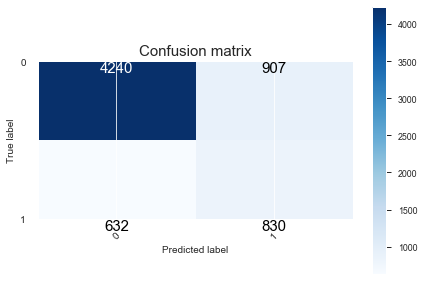

In [150]:
#Run logistic regression using the selected features
func.run_logistic(X_train_selected, X_test_selected, y_train, y_test)

dummy variables created
split done
original class distribution:
0    20424
1     6009
Name: default_payment_next_month, dtype: int64
synthetic sample class distribution:
1    15277
0    15277
dtype: int64


(26433, 52)

scaling done
Classification Report: 
               precision    recall  f1-score   support

           0       0.87      0.82      0.84      5147
           1       0.47      0.58      0.52      1462

    accuracy                           0.76      6609
   macro avg       0.67      0.70      0.68      6609
weighted avg       0.78      0.76      0.77      6609

AUC: 0.7467823552534953


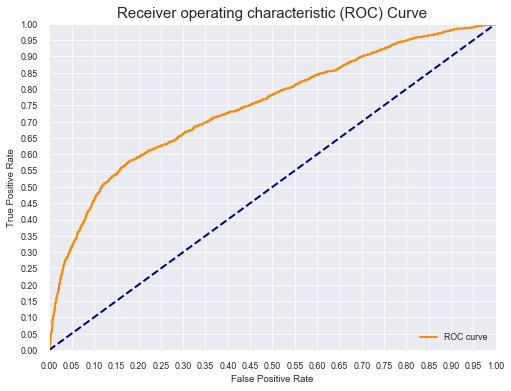

Confusion matrix, without normalization


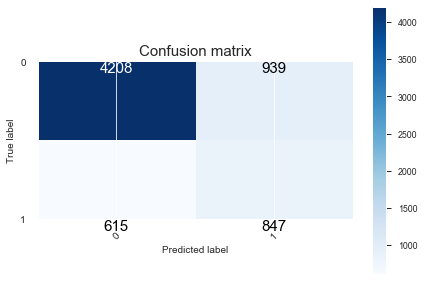

In [151]:
cat_columns = ['sex', 'education', 'marital_status', 'score_3mo', 'score_6mo']
cf_columns = ['age','limit_bal','limit_used_sep']

X, X_train_rs, X_test, y_train_rs, y_test = func.preprocess_data(df_final, cat_columns, cf_columns)
display(X.shape)
X_train_scaled, X_test_scaled = func.scale_X(X_train_rs, X_test)
func.run_logistic(X_train_scaled, X_test_scaled, y_train_rs, y_test)